In [2]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [17]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# Pair concordance
### Contents
    1. Pair concordance
    2. Confidence: bootstrapped interval
    3. Confidence: analytical interval

## 1. Pair concordance

Some text

In [25]:
# generate data
N = 100
S = np.round(np.random.rand(N), 1)
Y_ = np.round(S)

rand_idx = np.round( np.random.rand(np.int(N/5))*N).astype(int)
Y = Y_.copy()
for i in rand_idx:
    if Y[i] == 1.:
        Y[i] = 0.
    else:
        Y[i] = 1.

In [26]:
def concordance_computer(Y, S): # isn't this a cool name for a function?
    N_C = 0
    N_D = 0
    N_T_y = 0
    N_T_x = 0

    for i in range(0, len(S)):
        #print(i/len(S))                       # print statements to check that we are not double counting pairs
        for j in range(i+1, len(Y)):
            #print("      "+str(j/len(Y)))
            Y1 = Y[i]
            X1 = S[i]
            Y2 = Y[j]
            X2 = S[j]

            if Y1 > Y2 and X1 > X2:
                N_C += 1
            elif Y1 < Y2 and X1 < X2:
                N_C += 1
            elif Y1 > Y2 and X1 < X2:
                N_D += 1
            elif Y1 < Y2 and X1 > X2:
                N_D += 1
            elif Y1 == Y2:
                N_T_y += 1
            elif X1 == X2:
                N_T_x += 1

    N_tot = len(S)*(len(S)-1) / 2                        
    GK_Gamma = (N_C - N_D) / (N_C + N_D)              # note: we're not secure against zero-divisions
    SomersD = (N_C - N_D) / (N_tot - N_T_y)           # proper code shld implement some exception
    Kendall_tau =  (N_C - N_D) / np.sqrt((N_tot - N_T_y)*(N_tot - N_T_x))
    return GK_Gamma, SomersD, Kendall_tau

GK_Gamma, SomersD, Kendall_tau = concordance_computer(Y,S)


# should be GK_Gamma >= SomersD >=Kendall tau and GK_Gamma = Gini (for binary Y)
from sklearn.metrics import roc_auc_score
print("Gini: " + str(2* roc_auc_score(Y,S)-1))
print("GK Gamma: " + str(GK_Gamma))
print("SomersD: " + str(SomersD))
print("Kendall tau: " +str(Kendall_tau))


Gini: 0.5862626262626263
GK Gamma: 0.6208814719726145
SomersD: 0.5862626262626263
Kendall tau: 0.420452560354358


## 2. Confidence: bootstrapped interval

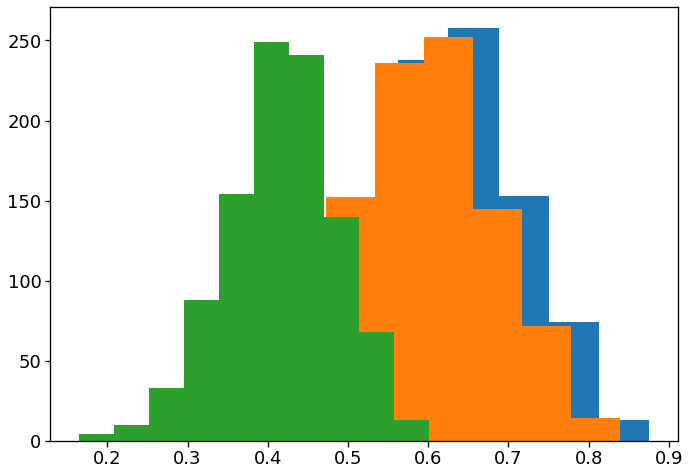

In [29]:
# Bootstrap:
# Within what CI lie the true statistic of these data?

n_iter = 1000
KG_boots = []
SD_boots = []
KT_boots = []

for i in range(n_iter):
    idx = (np.random.rand(N)*N).astype(int)
    # bootstrap pairs
    S_boots = S[idx]
    Y_boots = Y[idx]
    # compute statistics and append to store
    KG_tmp, SD_tmp, KT_tmp = concordance_computer(Y_boots, S_boots)
    KG_boots.append(KG_tmp)
    SD_boots.append(SD_tmp)
    KT_boots.append(KT_tmp)

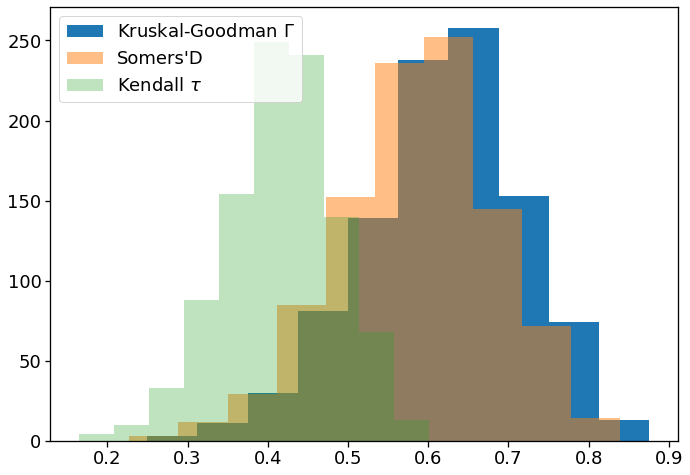

In [40]:
# check distr bootstrapped R2
# different cell to prevent rerunning the for-loop
plt.hist(KG_boots, label=r'Kruskal-Goodman $\Gamma$')
plt.hist(SD_boots, alpha = 0.5, label="Somers'D")
plt.hist(KT_boots, alpha = 0.3, label=r"Kendall $\tau$")
plt.legend()
plt.show()

In [48]:
def confidence_interval(bootstrapped_stats, alpha):
    """
    Return 2-sided symmetric confidence interval specified
    by p.
    """
    n = len(bootstrapped_stats)
    u_pval = 1 - alpha/2
    l_pval = alpha / 2
    l_idx = int(np.floor(n*l_pval))
    u_idx = int(np.floor(n*u_pval))
    return(bootstrapped_stats[l_idx], bootstrapped_stats[u_idx])

In [49]:
# CI KG-Gamma
bounds = confidence_interval(np.sort(KG_boots), 0.05)
print("With 95% confidence, the real KG lies within: (" + str(np.round(bounds[0],3)) + ", " + str(np.round(bounds[1],3)) + ")")
print("Observed KG: " + str(np.round(GK_Gamma, 3)))

With 95% confidence, the real KG lies within: (0.411, 0.793)
Observed KG: 0.621


In [46]:
# CI SomersD
bounds = confidence_interval(np.sort(SD_boots), 0.05)
print("With 95% confidence, the real SomersD lies within: (" + str(np.round(bounds[0],3)) + ", " + str(np.round(bounds[1],3)) + ")")
print("Observed SomersD: " + str(np.round(SomersD, 3)))

With 95% confidence, the real SomersD lies within: (0.381, 0.755)
Observed SomersD: 0.586


In [47]:
# CI Kendall tau
bounds = confidence_interval(np.sort(KT_boots), 0.05)
print("With 95% confidence, the real Kendall tau lies within: (" + str(np.round(bounds[0],3)) + ", " + str(np.round(bounds[1],3)) + ")")
print("Observed Kendall tau: " + str(np.round(Kendall_tau, 3)))

With 95% confidence, the rea Kendall tau lies within: (0.272, 0.541)
Observed Kendall tau: 0.42


## 3. Confidence: analytical interval

There are ways to compute the CI of the three stats analytically, but they assume normality (so big samples needed) and assume that (at least in the client docs) the pairs are bucketed, which is not the case in the data I have generated. 

As
    - I am too lazy to generate bucketed data, and
    - I see no reason why bootstrapping would not suffice here
I'll leave filling out this section for a later time or some other sentient being.